# Image classification with PyTorch

In this exercise we start to build our first (deep learning) model ot analyse images.
We use the famous MNIST data that was originally developed by Yann LeCun:  "THE MNIST DATABASE of handwritten digits". Yann LeCun, Courant Institute, NYU Corinna Cortes, Google Labs, New York Christopher J.C. Burges, Microsoft Research, Redmond.

The dataset contains about 70.000 images of hand-written digits 0-9, 60.000 of which are typically used for training, the rest for testing.
The images are normalised to a size of 28x28 pixels and anti-aliased which lead to the grayscale values that we can see in the data (as opposed a pure b/w image).
These data have the advantage that they are often included in the tools, and are small enough that we can train a neural network in reasonable time even without using GPUs.

A few years ago, the fashion company [Zalando](https://zalando.de) released a variant called [fahion-mnist](https://github.com/zalandoresearch/fashion-mnist) that can be used as a "drop-in" replacement, i.e. it has very similar properties: the same number of images for training and testing, the same size in terms of pixels, grayscale images, 10 classes, etc.
However, instead of showing just numbers, clothing items are choses (trousers, shirts,etc). The main motivations where that the original MNIST data are too easy for modern systems and can no longer really be used to develop modern algorithms.
However, in our case here we stick with the original data, as we want to explore how to setup a system and reduce our depencency on GPUs for now.

We will also make use of the [TorchVision](https://pytorch.org/vision/stable/index.html) library. This provides convenient access to a number of datasets (such as MNIST), but also pre-trained models or commonly used image augmentation methods.


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision as tv

import matplotlib.pyplot as plt
import numpy as np



# Data access

Now we download the data using the convenience function from TorchVision for the [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) data. It is essentially a wrapper function that downloads the data from Yann LeCun's webpage and add it to the local directory.

In [2]:
# Download training data from open datasets.
training_data = tv.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform=tv.transforms.ToTensor(),
)

# Download test data from open datasets.
test_data = tv.datasets.MNIST(
    root="data/mnist",
    train=False,
    download=True,
    transform=tv.transforms.ToTensor(),
)

Next, we need to make these data accessible to PyTorch.
This can be done using the [DataLoader](https://pytorch.org/docs/stable/data.html) provided by PyTorch. This function provides some common functionality when dealing with the data.
In particular, we will need to repeatedly access all images in the dataset and loop over them as the training progresses.
Further, experience shows that it is helpful to split the training data into smaller chunks (or batches) to speed up training. This is more efficient than updating the parameters of the network after each single image, or wait until we have processed the entire data in one training loop (or: epoch).
Here we will use a batch size of 64 (images) which works well - however, this is a free parameter and differnt values may work better in other situations.

After we have defined the DataLoaders for access to the data, we print an example. As we would normally loop over the data, we set the loop up here as well, but terminate it after the first image.

The array/vector/tensor ```X``` contains the images. Therfore, it's dimension reflect the batches of images we process:
- In each iteration, we train/test the network in batches of 64 images
- We have grayscale images (only one colour channel)
- the picture is 28x28 pixels high/wide

The array/vector/tensor ```y``` contains the corresponding true labels for each image (supervised training).

Note the grayscale values due to the anti-aliasing that was applied when creating the data.


Shape of X [N images per batch, # colours, height, width]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
True label: 7


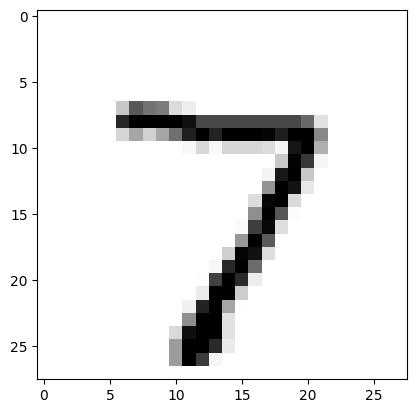

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# define the loop over the test data (even if we only use one image)
for X, y in test_dataloader:
    print("Shape of X [N images per batch, # colours, height, width]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)

    #print an example
    # since PyTorch tensors are of the form [#Channel, #pix X, #pix Y], need to 
    # transform back into image format
    index = 0
    plt.imshow(tv.transforms.ToPILImage()(X[index]), cmap='Greys')
    print('True label: {}'.format(y[index]) )
    break

# Network definition

Before we can train the network, we need to first setup the various components.
In particular, we need to define the architecture of the neural network, as well as the optimizer and other parameters that we use to train the network.

We start by defining the neural network.
In PyTorch, we do so by defining a class inheriting vom ```nn.Module```. We need to do two main steps:
- In the ```__init__()``` method: We need to define the components we want to use in our neural network model. Here we can make use of the many building blocks the PyTorch library provides us with and create the respective instances we need.
- In the ```forward()``` method: Here we define how the model is built from the various components defined in the ```init()``` method. This defines the *forward* pass of the network (from input to output), hence the name. The backward pass with the update of the network parameters using back-propagation is then handled automatically by PyTorch. Essentially, we need to "chain" the components together to define our model: The data (i.e. our images) enter the network through the input layer, go through all intermediate layers and then get to the output layer that provides us, for example, with the predictions for the labels (i.e. here, which number the image shows).

However, we also need to make sure that we move the model to GPU if we have one available (together with the data).

Generally, when building models working on images we use 
- [Convolutional](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layers for learnable image processing "filters"
- [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers, e.g. for classification of the labels using all the features learned by the previous (convolutional) layers.
- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or others as an activation function.
- [DropOut](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) or  [Dropout2D](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html) for regularisation.
- [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) as the pooling layer

When defining the model, we have two hard constraints:
- The input layer needs to be able to handle the 28x28x pixel grayscale images
- We need 10 nodes in the output layer (one for each digit 0-9).
How we set the intermediate layers up is, essentially, up to us and this is where the hard work of building and optimising a model comes in.

In a first step, we build a very simple network without convolutional layers. Therefore, we do not expect it to be very good or performant, but it will allow us to "learn the ropes" of how to train a neural network.
Since we only use "fully-connected" (or: "dense") layers, we first need to "flatten" the 2D image information into a long array that is 28*28 numbers long.
This is then passed into the input layer ```fc1```. We choose ```512``` output nodes for this layer. This is passed into the next layer, where we choose also ```512``` ouput nodes, before going to the output layer with ```10``` output nodes. In between, we use ```ReLU``` as activation function.


***Exercise*** \
Upgrade the model to use convolutional layers, e.g. two ```Conv2D``` layers with a ```(3,3)``` kernel, ```(1,1)``` stride, as well as 32 and 64 output channels. Then, also use ```maxpool2D``` after the convolutional layers and dropout in the "dense" part of the network for regularisation.



***Hint*** \
One of the tricky things to evaluate is the output size after pooling layers.
This [blog](https://androidkt.com/calculate-output-size-convolutional-pooling-layers-cnn/) has a nice illustrated intuition behind the formulae for convolutional and maxpool layers. This [repository](https://github.com/tuttelikz/conv_output_size) has a collection of helper functions, there is a pre-print [A guide to convolution arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) to discuss this in more detail.
You can also use this handy (web calculator)[http://layer-calc.com/] that gives you the size after all convolutional and maxpool layers.

For convolutional layers: \
```#output = Floor( ( #input - #filter + 2* #padding)/stride + 1)```

For maxpool layers: \
```#output = Floor (  (#input - #filter)/stride +1)```

*Note* \
We use the [Functional](https://pytorch.org/docs/stable/nn.functional.html) to pass the data through the various elements, e.g. the activation function.

In [4]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define  a simple model
#class NeuralNetwork(nn.Module):
#   def __init__(self):
#        super(NeuralNetwork, self).__init__()
#        self.flatten = nn.Flatten()
#        self.fc1 = nn.Linear(28*28, 512)
#        self.fc2 = nn.Linear(512, 512)
#        self.fc3 = nn.Linear(512, 10)
#        #self.linear_relu_stack = nn.Sequential(
#        #    nn.Linear(28*28, 512),
#        #    nn.ReLU(),
#        #    nn.Linear(512, 512),
#        #    nn.ReLU(),
#        #    nn.Linear(512, 10)
#        #)
#
#   def forward(self, x):
#       x = self.flatten(x)
#       #logits = self.linear_relu_stack(x)
#       # return logits
#       x = self.fc1(x)
#       x = F.relu(x)
#       x = self.fc2(x)
#       x = F.relu(x)
#       x = self.fc3(x)
#       return x

# Define a more complex model
class NeuralNetwork(nn.Module):
    def __init__(self):
      super(NeuralNetwork, self).__init__() 
      self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32, kernel_size= (3,3), stride= (1,1) )
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (3,3), stride= (1,1) )
      # calculate output after convolution layer 2:
      # #output = Floor( ( #input - #filter + 2* #padding)/stride + 1)
      # -> 28-3+1 = 26, one colour channel, 64 convolutional filters
      # -> 26 * 26 * 64 * 1
      #
      # calculate output after MaxPool layer:
      # #output = Floor (  (#input - #filter)/stride +1)
      #
      # here: 1* 64 * ( (26-2)/2) * ( (26-2)/2) = 9216
      # ( after two convolutional layers, with 64 filters in the second, and the down-sizing with the CNN layers and pooling, we
      #   to from a 28x28 pixel image (one colour channel) to a size of 12x12, for 64 filters )
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)

    def forward(self, x):
      x = self.conv1(x)
      x = F. relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=(2,2), stride=(2,2))
      x = torch.flatten(x,1)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)
      return x





model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
)


Next, we need to define the further parameters of the network.
Two very important ingredients are:
- the optimiser that is used to adjust the network weights during training
- the loss function 

The loss function allows us to quantify how well the network performs and how "good" the predictions are, i.e. how close the predicted label is to the true label. Since we work on a classification task, we use the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Instead of stochastic gradient descent [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html), we will use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam) optimiser, which is more efficient. We could also use, e.g. [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html?highlight=adam#torch.optim.AdamW) as a modern variant.
We need to pass the model parameters (i.e. the network weights) to the optimiser. This essentially "tells" the optimiser, which parameters need to be tuned during training.

In [5]:
##
## Optimizer and Loss Function
##
loss_fn = nn.CrossEntropyLoss()

# Choose the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Network training

Here we define the functions that run over the data and either train the network or evaluate the test data

The main skelleton is the same:
- we loop over batches over the data
- move the data to the device (CPU or GPU)
- calculate the predictions with the current state of the network (i.e., a forward pass)
- determine the quality of the prediction (i.e. the value of the loss function).

For the training loop, we then need to tell PyTorch to do the backward propagation and update the network weights.

Note:
- We need to tell PyTorch explictly if we train the model, so that the weights can get updated: ```model.train()```. Otherwise, we switch to evaluation mode ```model.eval()```.
- Our network has 10 output nodes, i.e. each note tells us how likely it is that this image corresponds to the label represented by this node. We need the node with the highest value to identify the most likely classification which we can do with ```argmax```.

In [6]:
#
# Training loop
#
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    running_loss = 0.0

    # put the model into training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # need to send the data tensors explicitly to the device we want to 
        # train on. E.g. when we create the tensors (and load the data),
        # they get created on the CPU, if we want to train on the GPU, 
        # we need to move it there explictly.
        X, y = X.to(device), y.to(device)

        #
        # Forward pass - compute the output of the network
        # (do not call forward() directly), "apply" the model on the data,
        # compute prediction error
        #
        pred = model(X)
        loss = loss_fn(pred, y)

        #
        # Backpropagation
        #

        # By default, the gradients accumulate, so we need to 
        # reset them explicitly at each new training step
        optimizer.zero_grad()

        # Now we need to calculate the gradients in all layers
        # in the backward pass. 
        # (For some reason, this is method is owned by the loss function)
        loss.backward()

        # After we calculated the gradients, we need to take the step
        # in the next best direction.
        # (For some reason, this method is owned by the optimizer)
        optimizer.step()

        # record loss functions // change loss -> loss_item ??
        loss_item = loss.item()
        current = batch * len(X)

        running_loss += loss_item
        if batch % 100 == 0:
            #loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss/size


#
# Test Loop
#
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # put the model into the evaluation mode.
    # some aspects (e.g. dropout, etc.) behave differently during
    # trainig and inference/evaluation
    model.eval()
    test_loss, correct = 0, 0

    # PyTorch stores gradient information by default - 
    # during inference we no longer need this as we won't update the
    # parameters anymore. Therefore, we can use "no_grad()" to switch that off.
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") 
    return correct

Now we use these functions for the actual training.

In [7]:
##
## The actual training/evaluation
##
epochs = 5
loss_values = []
accuracy_values = []

for t in range(epochs):

    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
    loss_values.append(loss)

    accuracy = test(test_dataloader, model, loss_fn)
    accuracy_values.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.316806  [    0/60000]


/home/kerzel/.cache/pypoetry/virtualenvs/damageclassification-lYD6-MH1-py3.10/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


loss: 0.346220  [ 6400/60000]
loss: 0.243524  [12800/60000]
loss: 0.155295  [19200/60000]
loss: 0.062000  [25600/60000]
loss: 0.185323  [32000/60000]
loss: 0.136340  [38400/60000]
loss: 0.186278  [44800/60000]
loss: 0.251663  [51200/60000]
loss: 0.187414  [57600/60000]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.052800 

Epoch 2
-------------------------------
loss: 0.050389  [    0/60000]
loss: 0.086836  [ 6400/60000]
loss: 0.048898  [12800/60000]
loss: 0.025702  [19200/60000]
loss: 0.074587  [25600/60000]
loss: 0.123194  [32000/60000]
loss: 0.157297  [38400/60000]
loss: 0.081875  [44800/60000]
loss: 0.144478  [51200/60000]
loss: 0.109090  [57600/60000]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.040735 

Epoch 3
-------------------------------
loss: 0.095249  [    0/60000]
loss: 0.150976  [ 6400/60000]
loss: 0.089556  [12800/60000]
loss: 0.106074  [19200/60000]
loss: 0.051212  [25600/60000]
loss: 0.033608  [32000/60000]
loss: 0.072492  [38400/60000]
loss: 0.081062  [44800/60000]
loss: 

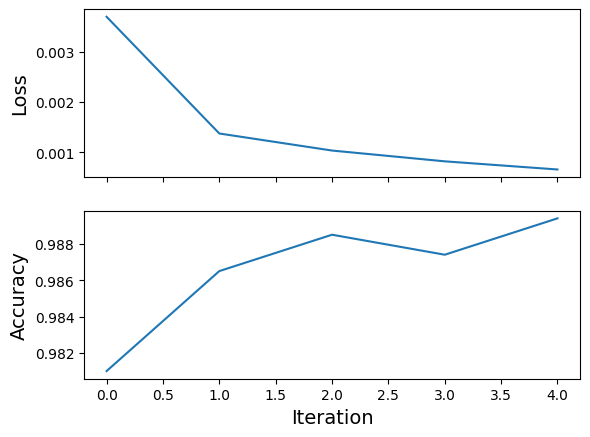

In [8]:
fig, axes = plt.subplots(2, sharex=True)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(loss_values)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].plot(accuracy_values)
plt.show()

Even with the very simple fully connected network, we can achive an accuracy of 96%-97%. This isn't bad as such, indeed, in many applications, this would be considered phenomenal. However, the best classifiers achieve around 99.8%, the code at [MNIST-0.17](https://github.com/Matuzas77/MNIST-0.17) has an error rate of only 0.17%.
This illustrates why we use MNIST for learning how to use neural networks for image processing and how to set the system up - but the data are not suitable (anymore) to develop performant neural network architectures.

The network with a few convolutional neural entwork layers is much better than the one without - we achieve an accuracy of 99% after just 5 epochs of training.
This is still quite far from the current state of the art, but then again, we do not want to build a model to beat it.
However, feel free to try and improve the model.